In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import math
import pysam as sam #处理fasta文件


## part1 数据清洗

In [ ]:
name = "PGDM1400"
file_route = '/home/dldx/xxy/GP160/data/'+name+".csv"
df = pd.read_csv(file_route)


In [ ]:
# 选取两个符号之间的字符
def txt_wrap_by(start_str, end, html):
        start = html.find(start_str)
        if start >= 0:
            start += len(start_str)
            end = html.find(end, start)
            if end >= 0:
                return html[start:end].strip()
        

In [ ]:
# 清洗IC50为UD的数据
for row in df.index:
    if df.loc[row, name+':IC50: geometric mean']=='UD':
        if df.loc[row, name+':IC50: by study'][0]=='>':
            ic50 = float(txt_wrap_by(">",":",df.loc[row, name+':IC50: by study']))*2
            df.loc[row, name+':IC50: geometric mean'] = ic50
        else:
            ic50 = float(txt_wrap_by("<",":",df.loc[row, name+':IC50: by study']))*2
            df.loc[row, name+':IC50: geometric mean'] = ic50

    


In [ ]:
# 删除IC50值为1的数据
df = df.drop(df[df[name+':IC50: geometric mean']=='1'].index)

In [ ]:
df.index = range(len(df))

In [ ]:
# 保存csv
df.to_csv(file_route)

## part2 抗体-病毒数量统计

In [3]:
path = "./data/antibody"
files = os.listdir(path)
antibody = []
for file in files:
    antibody.append(os.path.splitext(file)[0])
antibody = dict.fromkeys(antibody)


In [11]:
mean = []
std = []
for file in files:
    file_route = path + "/" + file
    df = pd.read_csv(file_route)
    antibody[os.path.splitext(file)[0]] = len(df)
    mean.append(np.array(df["IC50"]).mean())
    std.append(np.array(df["IC50"]).std())
print(antibody)

{'PG9': 810, '10-1074': 865, 'PGT121': 1061, 'b12': 867, '2G12': 906, '3BNC117': 901, 'PGDM1400': 812, '2F5': 884, 'VCR01': 1059, '4E10': 884}


In [13]:
d = {
    "antibody": pd.Series(antibody.keys()),
    "vir_num": pd.Series(antibody.values()),
    "IC50_mean": mean,
    "IC50_std": std
}
df = pd.DataFrame(d)
df.to_csv("./data_process_result/antibody_statistic.csv")

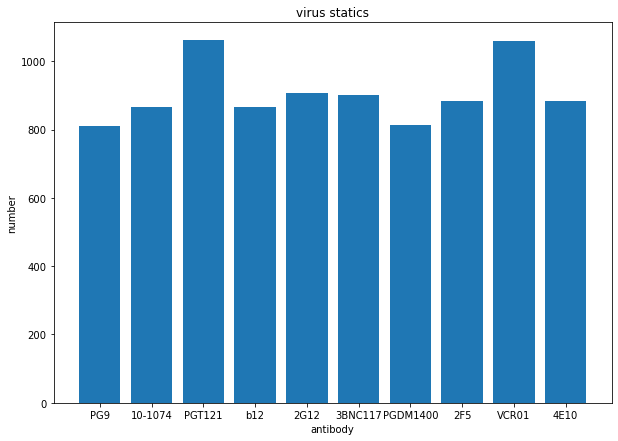

In [37]:
import matplotlib.pyplot as plt

x = np.array(list(antibody.keys()))
y = np.array(list(antibody.values()))
plt.subplots(figsize=(10, 7))
plt.title("virus statics")
plt.xlabel("antibody")
plt.ylabel("number")
plt.bar(x,y)

plt.show()

## Part3. 统计每种抗体对应病毒的地区和亚型

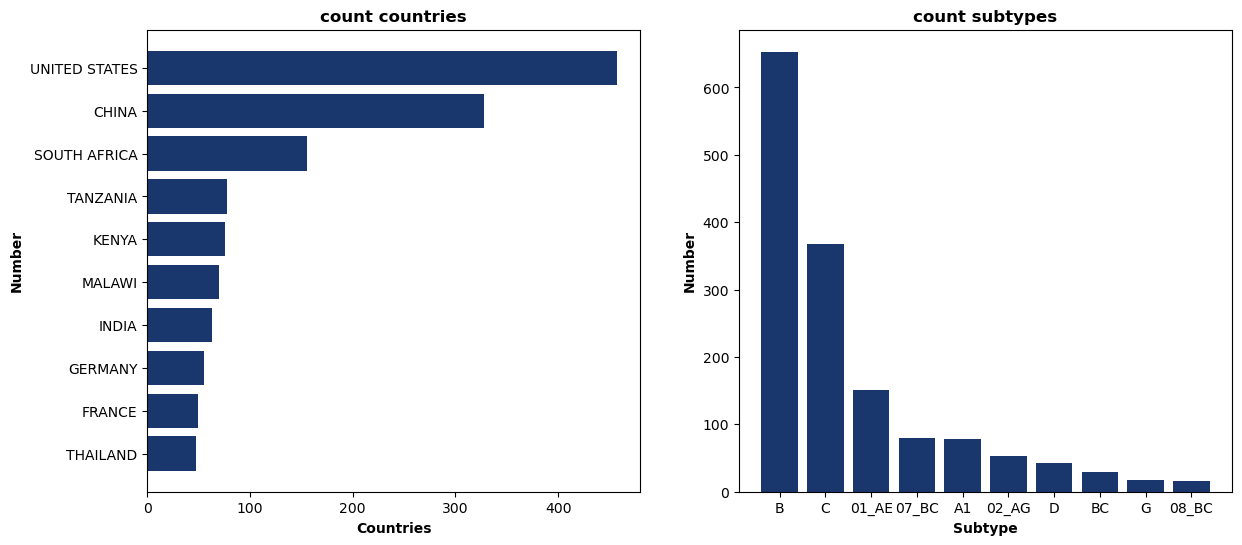

In [62]:
df = pd.read_csv("./data/virus/viruses.csv")
df = df.drop(df[df['Seq data']=='No'].index)

# statistical countries of viruses
country = df["Country"].value_counts()
subtype = df["Subtype"].value_counts()

fig = plt.figure(figsize=(14,6))
# plot1
plt.subplot(1,2,1)
plt.xlabel("Countries", weight = "bold")
plt.ylabel("Number", weight = "bold")
plt.barh(np.array(country.index[:10])[::-1], np.array(country.values[:10])[::-1], color="#19376D")
plt.title("count countries", weight = "bold")

# plot2
plt.subplot(1,2,2)
plt.xlabel("Subtype", weight = "bold")
plt.ylabel("Number", weight = "bold")
plt.bar(subtype.index[:10], subtype.values[:10], color="#19376D")
plt.title("count subtypes", weight = "bold")

plt.show()

In [228]:
dic = {}
for file in files:
    file_route = path + "/" + file
    df = pd.read_csv(file_route)
    dic[file[:-4]] = pd.Series(list(df["IC50"]))
count_IC50 = pd.DataFrame(dic)



In [229]:
count_IC50.to_csv("./data_process_result/IC50_count.csv")

In [33]:
count_IC50 = pd.read_csv("./data_process_result/IC50_count.csv")
count_IC50.drop(count_IC50.columns[0:2], axis=1, inplace=True)
count_IC50.to_csv("./data_process_result/IC50_count.csv")
count_IC50.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1061 entries, 0 to 1060
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PG9       810 non-null    float64
 1   10-1074   865 non-null    float64
 2   PGT121    1061 non-null   float64
 3   b12       867 non-null    float64
 4   2G12      906 non-null    float64
 5   3BNC117   901 non-null    float64
 6   PGDM1400  812 non-null    float64
 7   2F5       884 non-null    float64
 8   VCR01     1059 non-null   float64
 9   4E10      884 non-null    float64
dtypes: float64(10)
memory usage: 83.0 KB


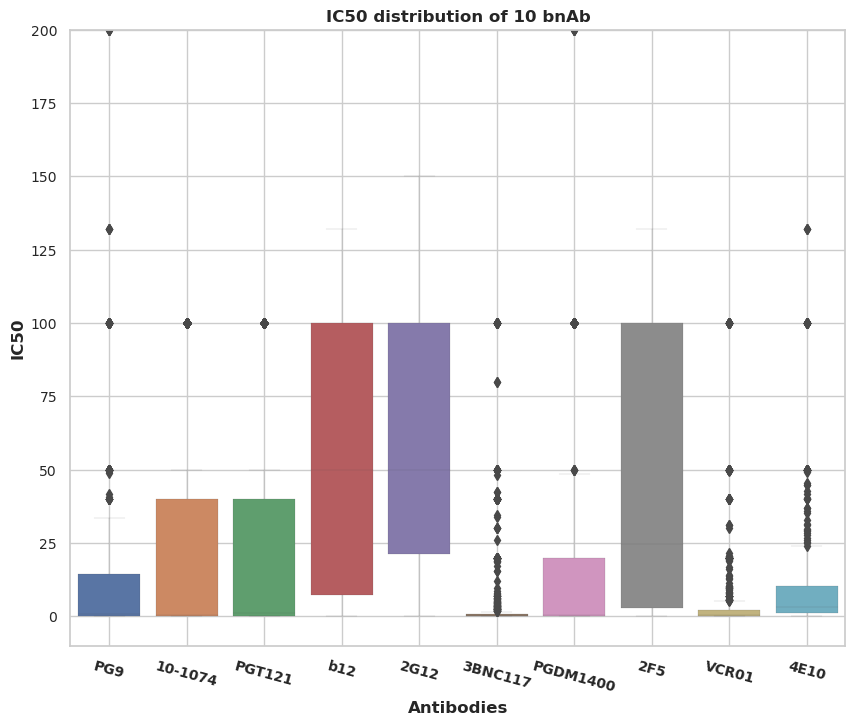

In [45]:
plt.figure(figsize = (10,8))
plt.title("IC50 distribution of 10 bnAb", weight="bold")
plt.xlabel("Antibodies", weight="bold")
plt.ylabel("IC50", weight="bold")
plt.xticks(fontsize=10, rotation=-15, weight="bold")  # 设置x轴刻度字体大小
plt.yticks(fontsize=10)  # 设置y轴刻度字体大小

sns.boxplot(data=count_IC50, linewidth=0.1, width=0.8)
plt.grid(axis='x')
plt.ylim(-10, 200)
# plt.savefig("./plots/Probability_density_statistics.png")
plt.show()

## Part4. process fasta

In [11]:
fasta = sam.FastaFile('./data/virus/virus_seq.fasta')
path = "./data/antibody"
files = os.listdir(path)

In [12]:

for file in files:
    print(file)
    dic = {}
    seq = []
    ali_seq = []
    virus_name = []
    IC50 = []
    seq_len = []
    ali_seq_len = []
    file_route = path + "/" + file
    df = pd.read_csv(file_route)
    for row in df.index:
        
        Subtype = ""
        Country = ""
        Year = ""
        Virus_name = ""
        Accession = ""
# modify wrong country names
        if df.loc[row, "Country"]=='UNITED STATES':
            df.loc[row, "Country"]='UNITED_STATES'
        if df.loc[row, "Country"]=='SOUTH AFRICA':
            df.loc[row, "Country"]='SOUTH_AFRICA'
        if df.loc[row, "Country"]=="COTE D'IVOIRE":
            df.loc[row, "Country"]="COTE_D'IVOIRE"
        if df.loc[row, "Country"]=="DEM REP OF CONGO":
            df.loc[row, "Country"]="DEM_REP_OF_CONGO"
        if df.loc[row, "Country"]=='TRINIDAD AND TOBAGO':
            df.loc[row, "Country"]='TRINIDAD_AND_TOBAGO'
        if df.loc[row, "Country"]=='UNITED KINGDOM':
            df.loc[row, "Country"]='UNITED_KINGDOM'
        if df.loc[row, "Country"]=='DOMINICAN REPUBLIC':
            df.loc[row, "Country"]='DOMINICAN_REPUBLIC'
        if df.loc[row, "Country"]=='RUSSIAN FEDERATION':
            df.loc[row, "Country"]='RUSSIAN_FEDERATION'
        if df.loc[row, "Virus name"]=='R880F_ENV':
            df.loc[row, "Virus name"]='R880F'





        if not pd.isna(df.loc[row, "Subtype"]):
            Subtype = df.loc[row, "Subtype"]
        if not pd.isna(df.loc[row, "Country"]):
            Country = df.loc[row, "Country"]
        if not pd.isna(df.loc[row, "Year"]):
            Year = int(df.loc[row, "Year"])
        if not pd.isna(df.loc[row, "Virus name"]):
            Virus_name = df.loc[row, "Virus name"]
        if not pd.isna(df.loc[row, "Accession"]):
            Accession = df.loc[row, "Accession"]

        name = str(Subtype) + "." + str(Country) + "." + str(Year) + "." + str(Virus_name) + "." + str(Accession)
        sequence = fasta.fetch(fasta.references[fasta.references.index(name)], 0, 1041).replace("-","").replace("*","").replace("#","")
        ali_sequence = fasta.fetch(fasta.references[fasta.references.index(name)], 0, 1041)
        
        seq.append(sequence)
        ali_seq.append(ali_sequence)
        seq_len.append(len(sequence))
        ali_seq_len.append(len(ali_sequence))
        virus_name.append(str(df.loc[row, "Virus name"]))
        IC50.append(round(df.loc[row, "IC50"], 3))
    
    dic = {"virus_name": virus_name, "sequence": seq, "ali_sequence": ali_seq, "IC50": IC50, "seq_len": seq_len, "ali_seq_len": ali_seq_len}
    antibody_df = pd.DataFrame(dic)
    antibody_df.to_csv("./data/processed_data/"+file)





PG9.csv
10-1074.csv
PGT121.csv
b12.csv
2G12.csv
3BNC117.csv
PGDM1400.csv
2F5.csv
VCR01.csv
4E10.csv


## Part5. 统计病毒长度

In [ ]:
path = "./data/processed_data"
files = os.listdir(path)
dic = {}
for file in files:
    file_route = path+"/"+file
    df = pd.read_csv(file_route)
    for index in range(len(df)):
        df.loc[index, "seq_len"] = len(df.loc[index, "sequence"])
    df.to_csv(file_route)
    dic[file[:-4]] = pd.Series(list(df["seq_len"]))
    
count_length = pd.DataFrame(dic)



In [19]:
count_length.to_csv("./data_process_result/length_count.csv")

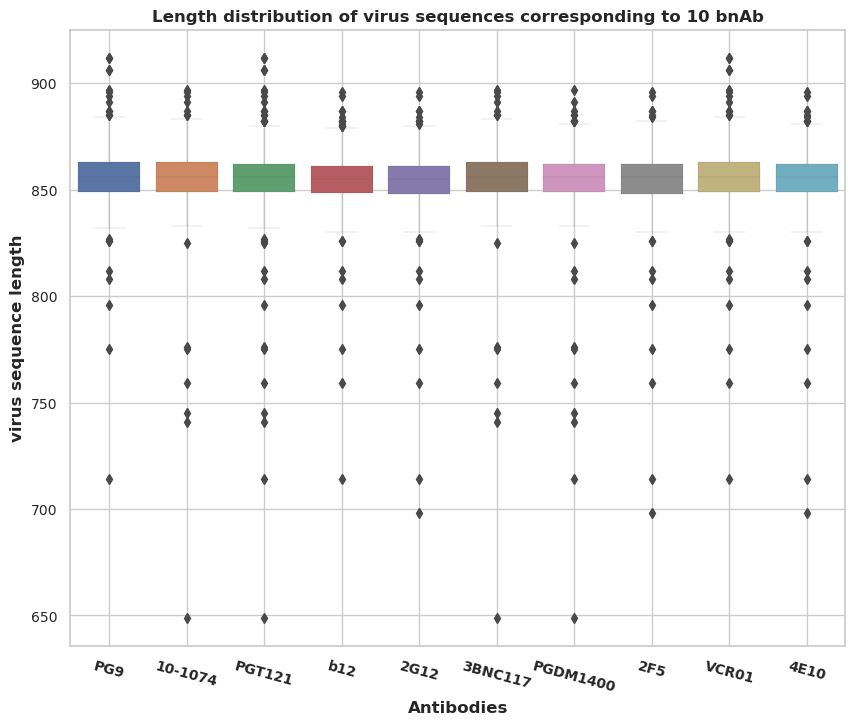

In [48]:
plt.figure(figsize = (10,8))
plt.title("Length distribution of virus sequences corresponding to 10 bnAb", weight="bold")
plt.xlabel("Antibodies", weight="bold")
plt.ylabel("virus sequence length", weight="bold")
plt.xticks(fontsize=10, rotation=-15, weight="bold")  # 设置x轴刻度字体大小
plt.yticks(fontsize=10)  # 设置y轴刻度字体大小

sns.boxplot(data=count_length, linewidth=0.1, width=0.8)
plt.grid(axis='x')
# plt.ylim(-10, 200)
# plt.savefig("./plots/Probability_density_statistics.png")
plt.show()

## Part6. Search v1-v5 from aa sequences

#### 1. PGT121

In [14]:
fasta = sam.FastaFile('./data/virus/PGT121_aa.fasta')
HXB2_seq = list(fasta.fetch("HXB2",))
HXB2 = pd.DataFrame(data=HXB2_seq, columns=["aa"])

i = 1
for index in range(len(HXB2)):
    if HXB2.loc[index, "aa"].isalpha():
        HXB2.loc[index, "position"] = i
        i +=1
HXB2.to_csv("./data/virus/PGT121_HXB2.csv") 
#v1[160:300] v2[211:286] v3[393:433] v4[505:550]

In [20]:
df = pd.read_csv("./data/antibody/PGT121.csv")
dic = {}
seq = []
ali_seq = [] 
virus_name = []
IC50 = []
seq_len = []
ali_seq_len = []
v1 = []
v2 = []
v3 = []
v4 = []
# file_route = path + "/" + file
# df = pd.read_csv(file_route)
for row in df.index:
    sequence = fasta.fetch(fasta.references[row+1],).replace("-","").replace("*","").replace("#","")
    ali_sequence = fasta.fetch(fasta.references[row+1],)
    
    seq.append(sequence)
    ali_seq.append(ali_sequence)
    seq_len.append(len(sequence))
    ali_seq_len.append(len(ali_sequence))
    virus_name.append(str(df.loc[row, "Virus name"]))
    IC50.append(round(df.loc[row, "IC50"], 4))
    v1.append(ali_sequence[160:300])
    v2.append(ali_sequence[211:286])
    v3.append(ali_sequence[393:433])
    v4.append(ali_sequence[505:550])

dic = {"virus_name": virus_name, "sequence": seq, "ali_sequence": ali_seq, "v1":v1, "v2":v2, "v3":v3, "v4":v4, "IC50": IC50, "seq_len": seq_len, "ali_seq_len": ali_seq_len}
antibody_df = pd.DataFrame(dic)
antibody_df.to_csv("./data/processed_data2/PGT121.csv")

#### 2. VRC01

In [3]:
fasta = sam.FastaFile('./data/virus/VRC01_aa.fasta')
HXB2_seq = list(fasta.fetch("HXB2",))
HXB2 = pd.DataFrame(data=HXB2_seq, columns=["aa"])

i = 1
for index in range(len(HXB2)):
    if HXB2.loc[index, "aa"].isalpha():
        HXB2.loc[index, "position"] = i
        i +=1
HXB2.to_csv("./data/virus/VRC01_HXB2.csv") 
#v1[157:207] v2[208:282] v3[389:429] v4[500:546]

In [4]:
df = pd.read_csv("./data/antibody/VRC01.csv")
dic = {}
seq = []
ali_seq = [] 
virus_name = []
IC50 = []
seq_len = []
ali_seq_len = []
v1 = []
v2 = []
v3 = []
v4 = []
# file_route = path + "/" + file
# df = pd.read_csv(file_route)
for row in df.index:
    sequence = fasta.fetch(fasta.references[row+1],).replace("-","").replace("*","").replace("#","")
    ali_sequence = fasta.fetch(fasta.references[row+1],)
    
    seq.append(sequence)
    ali_seq.append(ali_sequence)
    seq_len.append(len(sequence))
    ali_seq_len.append(len(ali_sequence))
    virus_name.append(str(df.loc[row, "Virus name"]))
    IC50.append(round(df.loc[row, "IC50"], 4))
    v1.append(ali_sequence[157:207])
    v2.append(ali_sequence[208:282])
    v3.append(ali_sequence[389:429])
    v4.append(ali_sequence[500:546])

dic = {"virus_name": virus_name, "sequence": seq, "ali_sequence": ali_seq, "v1":v1, "v2":v2, "v3":v3, "v4":v4, "IC50": IC50, "seq_len": seq_len, "ali_seq_len": ali_seq_len}
antibody_df = pd.DataFrame(dic)
antibody_df.to_csv("./data/processed_data2/VRC01.csv")